In [90]:
import pandas as pd, numpy as np

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%a\n%m/%d')

import seaborn as sns

In [91]:
from sklearn.linear_model import LinearRegression

In [92]:
# Import COVID data from the NY Times
path = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv"
covid = pd.read_csv(path)
covid['date'] = pd.to_datetime(covid.date)

# Import census population data by county for 2018
path = 'http://www.wtad.com/assets/news_files/PEP_2018_PEPANNCHG.ST05_with_ann.xlsx'
pop = pd.read_excel(path)
pop = pop.rename(columns={'GC.target-geo-id2':'fips',
                'respop72018':'population'})
pop = pop[['fips','population']]
pop = pop.loc[1:]
pop['population'] = pd.to_numeric(pop['population'])
pop['fips'] = pd.to_numeric(pop.fips)

In [93]:
# Import MSA mapping 
# Clean up MSA names to keep the major city and state
path = "https://raw.githubusercontent.com/dri3s/covidviz/master/metrolist.csv"
msa = pd.read_csv(path, nrows=1160, header=None, names=['msa_fips','msa_name','fips','county_name'])

msa.fips = pd.to_numeric(msa['fips'])
msa = msa.drop(columns=['msa_fips','county_name'])

msasplit = msa.msa_name.str.split(pat=',|-', expand=True)
msasplit['state'] = None

for idx, row in msasplit.iterrows():
    for col in row:
        try:
            state = col.strip()[0:2]
            if state.isupper() and msasplit.loc[idx, 'state'] == None:
                msasplit.loc[idx, 'state'] = state
                continue
        except:
            continue

msasplit = msasplit.rename(columns={0:'city'})

msasplit = msasplit[['city','state']]
msa[['city','state']] = msasplit
msa['msa_name'] = msa.city + ', ' + msa.state

In [94]:
# Make sure there are records for every single day - fill null values with zeroes
calshell = pd.DataFrame(covid.date.unique(), columns=['date'])
calshell['key'] = 1
pop['key'] = 1
covidmsa = calshell.merge(pop).merge(msa).merge(covid, how='left', on=['fips','date'])
covidmsa = covidmsa.fillna(0)

In [95]:
# Combine covid, population, and MSA data
# Sum by MSA and compute cases per capita
covidmsa = covidmsa.drop(columns=['fips','key']).groupby(['date','msa_name']).sum().reset_index()
covidmsa['caseperk'] = (covidmsa.cases/covidmsa['population']) * 1000
covidmsa = covidmsa.sort_values(by=['msa_name','date']).reset_index(drop=True)
covidmsa = covidmsa.loc[covidmsa.cases >= 10]
covidmsa ['num_days'] = (covidmsa.date - covidmsa.groupby(['msa_name'])['date'].transform('min')).dt.days

In [96]:
covidmsa.loc[covidmsa.date == covidmsa.date.max()].sort_values('caseperk')

,date,msa_name,population,cases,deaths,caseperk,num_days
5739,2020-04-11,"Chico, CA",231256,14.0,0.0,0.060539,9
12217,2020-04-11,"Hanford, CA",151366,10.0,1.0,0.066065,0
31241,2020-04-11,"Yuma, AZ",212128,15.0,0.0,0.070712,12
30011,2020-04-11,"Wausau, WI",163117,13.0,1.0,0.079697,7
737,2020-04-11,"Altoona, PA",122492,10.0,0.0,0.081638,0
...,...,...,...,...,...,...,...
3853,2020-04-11,"Bridgeport, CT",943823,5407.0,220.0,5.728828,28
20335,2020-04-11,"New York, NY",19303808,121539.0,4154.0,6.296115,38
22713,2020-04-11,"Poughkeepsie, NY",675669,6591.0,126.0,9.754776,28
20253,2020-04-11,"New Orleans, LA",1270399,12887.0,526.0,10.144057,31


In [97]:
# Mark the 10 worst MSAs and include others of interest
worst = list(covidmsa.groupby('msa_name').
             caseperk.max().reset_index().
             sort_values('caseperk').tail(10).msa_name.values)

dets = list(covidmsa.loc[covidmsa.msa_name.str.contains('Dallas')].msa_name.unique())
dets.append(covidmsa.loc[covidmsa.msa_name.str.contains('Houston')].msa_name.unique()[0])

# These are cities with quarantine facilities that had lots of patients early on 
# They are outliers and should be excluded
exclude = ['San Antonio, TX','Omaha, NE','Vallejo, CA']

Text(0.9, 0.01, 'Data current through 04/11')

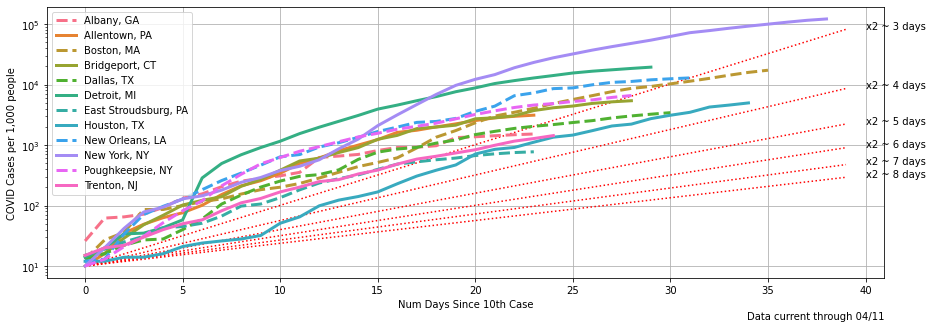

In [140]:
exp = pd.DataFrame(np.arange(40), columns=['num_days'])
ds = list(range(3, 9))
for d in ds:
    exp['double{}'.format(d)] = 10 * np.exp(exp.num_days * (np.log(2)/d))

colors = iter(sns.color_palette('husl', len(worst) + len(dets)))

plt.rcParams['figure.figsize'] = 15, 5
fig, ax = plt.subplots()

for d in ds:
    ys = exp['double{}'.format(d)]
    ax.plot(exp.num_days, ys, ls='dotted', color='red')
    plt.text(exp.num_days.max() + 1, ys.max(), 'x2 ~ {} days'.format(d))


i = 0

for msaname, df in covidmsa.groupby('msa_name'):    
    if msaname in exclude:
        continue
    
    df = df.sort_values(by='caseperk')
    
    if msaname in worst or msaname in dets:
        label = msaname
        color = next(colors)
        lw, alpha = (3, 1)
        
        if i%2 == 0: ls = '--'
        else: ls = '-'
            
        i += 1
    else:   
        continue
        label = '_nolabel_'
        color='gray'
        lw, alpha = (0.4, 0.4)
        ls = '-'
        
    if msaname in dets:        
        #lw = 5    
        pass
    
    #ax.plot(covidmsa.loc[covidmsa.fips == fips]['date'],
    ax.plot(df['num_days'],
            df['cases'], 
            label=label,
            color=color,
            lw=lw,
            alpha=alpha,
            ls = ls
            )    
    
    
#ax.set_xlim([pd.to_datetime('15feb2020'),pd.to_datetime(date.today())])
#ax.xaxis.set_major_formatter(myFmt)
#ax.xaxis.set_major_locator(mdates.WeekdayLocator(mdates.MO))

#ax.set_xlim([0, covidmsa.num_days.max()])

ax.set_yscale('log')

ax.set_ylabel('COVID Cases per 1,000 people')
ax.set_xlabel('Num Days Since 10th Case')
ax.legend()
ax.grid()

plt.figtext(0.9, 0.01, 'Data current through {:%m/%d}'.format(covidmsa.date.max()), horizontalalignment='right') 

In [100]:
df = covidmsa.loc[covidmsa.msa_name == 'Houston, TX'].copy().reset_index()

df['lncase'] = np.log(df.cases)

outnums = []
for i in range(0, len(df) - 7):
    X = df.loc[i:i+7, 'num_days'].values.reshape(-1, 1)
    y = df.loc[i:i+7, 'lncase'].values
    
    reg = LinearRegression().fit(X, y)
    print(round(1/reg.coef_[0], 2), X.max())
    outnums.append(1/reg.coef_[0])

8.21 7
7.7 8
7.75 9
6.24 10
5.53 11
4.67 12
3.98 13
3.67 14
3.65 15
3.77 16
4.08 17
4.17 18
4.37 19
3.99 20
3.79 21
3.98 22
4.35 23
4.7 24
5.23 25
5.86 26
6.65 27
6.88 28
6.68 29
6.92 30
7.09 31
6.78 32
7.07 33
7.5 34


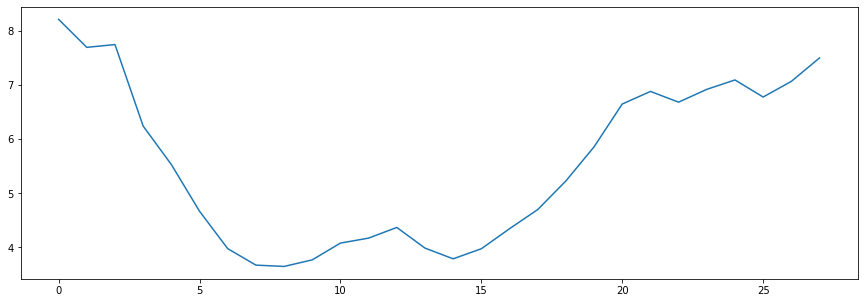

In [102]:
fig, ax = plt.subplots()
ax.plot(outnums)

In [67]:
df['lncase'] = np.log(df.cases)

X = df.tail(7).num_days.values.reshape(-1, 1)
y = df.tail(7).lncase.values

reg = LinearRegression().fit(X, y)

In [68]:
print(1/reg.coef_[0])

12.355515684759233


In [59]:
y

array([1.63830028, 1.74758396, 1.90905339, 1.93632938, 2.05491943,
       2.14658368, 2.18219199])

In [58]:
y.min()/y.max()

0.7507590026080153